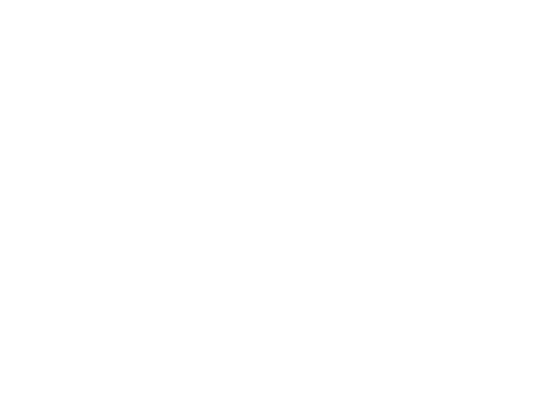

In [1]:
data_dir = '/home/trevor/research/AFRL/Box/Data/Yellowstone';
classifier_dir = '/home/trevor/research/AFRL/Box/Data/Yellowstone';
hits_dir = '/home/trevor/research/AFRL/Box/Data/Yellowstone/';

data_filename = 'yellowstone_wfov_20160928.processed.h5';  
hits_filename = 'fish_hits_2016_with_school_size_estimates.csv';

PLANE_TO_SURFACE = 160;
SURFACE_PAD = 0;
MAX_INTENSITY = 11;
MIN_INTENSITY = 2;

cmap = flip(colormap('gray'));

# Load in the dataset

In [2]:
full_filepath = [data_dir filesep data_filename];
xpol_from_plane = h5read(full_filepath, '/crosspol/radiance');
surf_idx = h5read(full_filepath, '/info/surface_index');
distance = h5read(full_filepath, '/location/distance');
latlong = h5read(full_filepath, '/location/latlong');

% Get the image dimensions; this assumes the image has more columns than rows
IMAGE_HEIGHT = min(size(xpol_from_plane));
IMAGE_WIDTH = max(size(xpol_from_plane));

# Create labels

## Load in CSV file

In [3]:
full_filepath = [hits_dir filesep hits_filename];

hits_matrix = readmatrix(full_filepath);                                    % Initialize hits values

%% Set the distances from the csv file
fish_distances = hits_matrix(:, 1);                                            % Initializing vectors of preselected fish hit data
fish_latitudes = hits_matrix(:, 2);                                            % (All rows, second column)
fish_longitudes = hits_matrix(:, 3);
school_sizes = hits_matrix(:, 7);

## Create the label vector

In [4]:
AVG_WIDTH_PER_FISH = 4.57;
human_labels = create_positive_label_vect(AVG_WIDTH_PER_FISH, school_sizes, distance, fish_distances);

## Widen the labeled areas for visualization

In [5]:
window = 2500;
index = window;
while index < length(human_labels)
    if human_labels(index) == 1
            human_labels((index-window/2):(index+window/2)) = 1;
            index = index + window;
    else
            index = index + 1;
    end
end

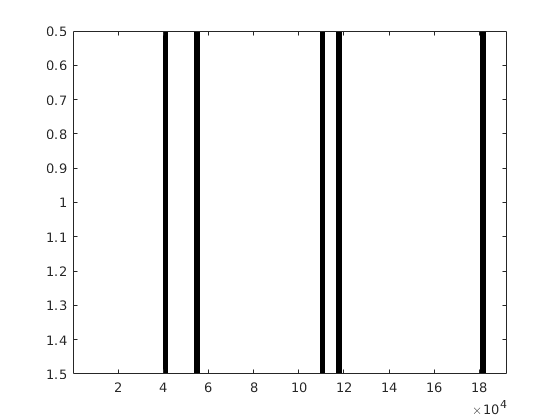

In [6]:
imagesc(human_labels)
colormap(cmap)

# Data preprocessing

## Normalize surface index
The height of the water does not start at the same row in each LIDAR
shot. This could potentially cause problems with shift-variant
classifiers, so we want the height of the water to always start at 
the same row in every LIDAR shot. 

In [7]:
xpol_normalized = normalize_surface_height(xpol_from_plane, surf_idx, SURFACE_PAD);

## Dimensionality reduction
Reduce column height to region of interest. The resulting image height
needs to be the same as what the classifier was trained against, which 
in this case is 60. 

In [8]:
REDUCED_COLUMN_HEIGHT = 60;
xpol_normalized = xpol_normalized(1:REDUCED_COLUMN_HEIGHT,:);

## Thresholding

In [9]:
xpol_thresholded = xpol_normalized;
xpol_thresholded(xpol_thresholded < MIN_INTENSITY) = 0;
xpol_thresholded(xpol_thresholded > MAX_INTENSITY) = MAX_INTENSITY;

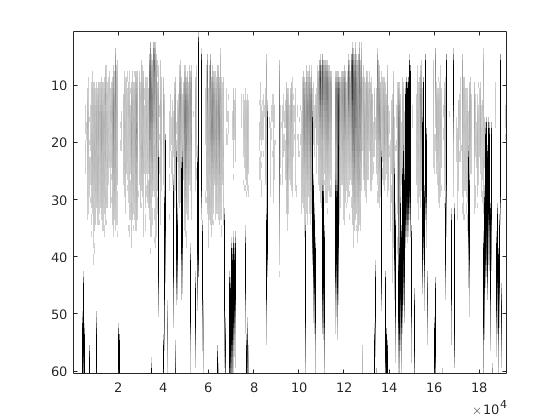

In [10]:
imagesc(xpol_thresholded)
colormap(cmap)

# Median filter
Try removing some of the background information with a median filter. 

Some quick experimentation suggests that 50 is a reasonable window length for the median filter

In [11]:
median_window_length = 50;
xpol_median = movmedian(xpol_normalized, median_window_length);
xpol_minus_median = xpol_normalized - xpol_median;

Also try thresholding the min and max intensities after removing the median

In [12]:
xpol_minus_median_thresholded = xpol_minus_median;
xpol_minus_median_thresholded(xpol_minus_median_thresholded < MIN_INTENSITY) = 0;
xpol_minus_median_thresholded(xpol_minus_median_thresholded > MAX_INTENSITY) = MAX_INTENSITY;

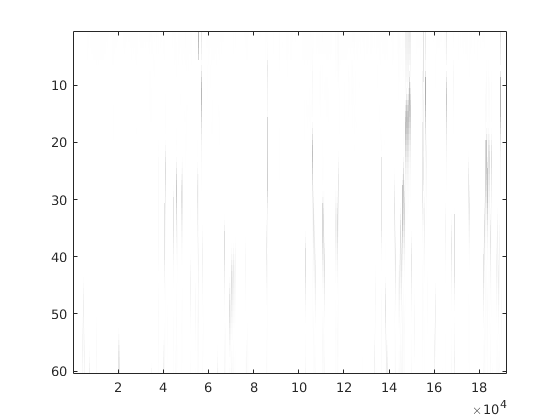

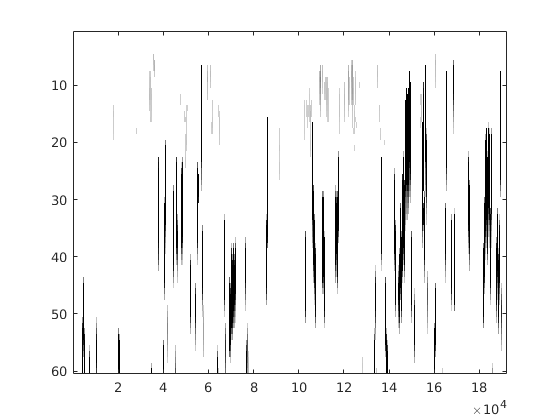

In [13]:
imagesc(abs(xpol_minus_median))
colormap(cmap)
figure
imagesc(xpol_minus_median_thresholded)
colormap(cmap)

## Standard deviation
Use a sliding standard deviation window to get a measure of how much the signal is changing

I don't recall what the spot size of the lidar used to capture the Yellowstone data is, but the window length should be probably be related to the distances we are interested in obversing changes over. In the Gulf of Mexico data, the spot size is 5 meters.

A window length of 20 seems to make physical sense, but the results do not look much different from the simple thresholding results. A window length of 50 has a more drastic effect in spreading the signal intensity out.

In [14]:
std_window_length = 50;
xpol_std = movstd(xpol_normalized, std_window_length);

% thresholding the std deviation might produce different results 
% from computing the std deviation of the thresholded data
xpol_thresholded_std = movstd(xpol_thresholded, std_window_length);

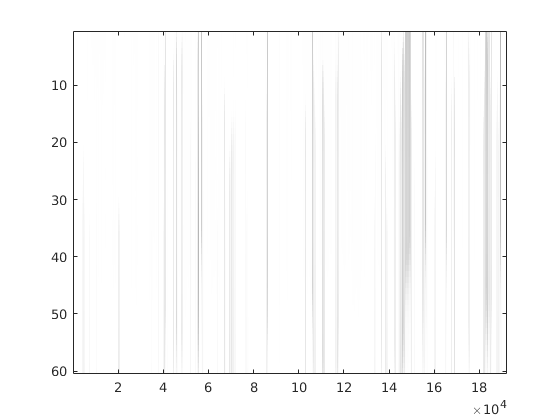

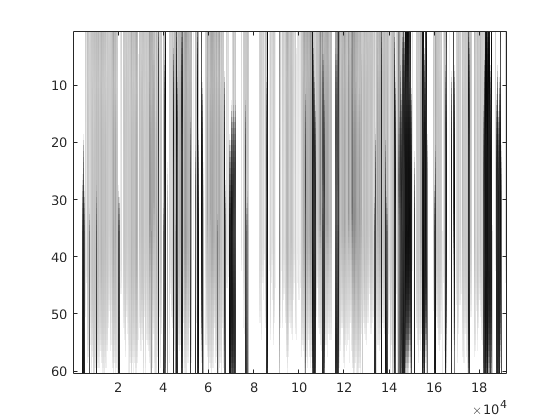

In [15]:
imagesc(xpol_std)
colormap(cmap)
figure
imagesc(xpol_thresholded_std)
colormap(cmap)

# Comparison
Look at how each of the preprocessing techniques compare to the human labeled areas.

Looking at the following plots, it seems like the simple thresholding technique is very comparable to the other techniques. None of the plots really illuminate any salient features that definitively identify a fish group. 

Applying a threshold after the median filter does remove some uninteresting background clutter.

## Simple thresholding

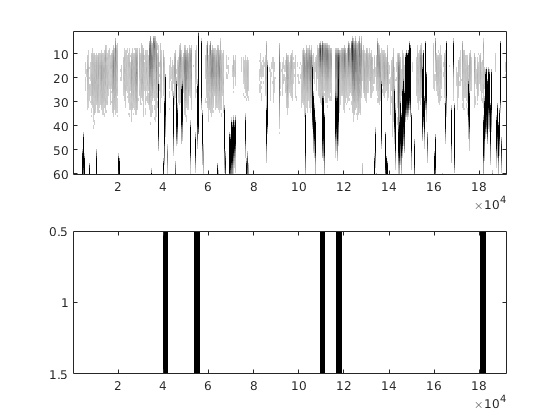

In [16]:
subplot(2,1,1)
imagesc(xpol_thresholded)
colormap(cmap)
subplot(2,1,2)
imagesc(human_labels)
colormap(cmap)

## Moving median filter

### Without thresholding

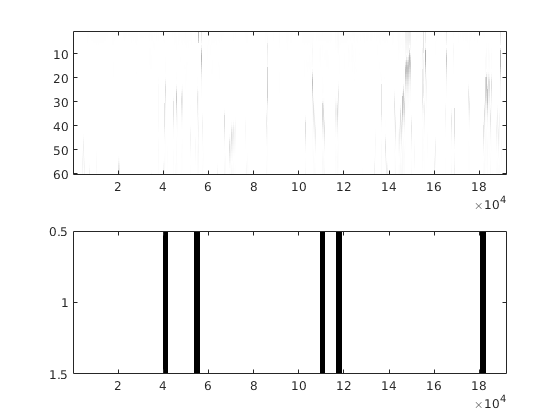

In [17]:
subplot(2,1,1)
imagesc(abs(xpol_minus_median))
colormap(cmap)
subplot(2,1,2)
imagesc(human_labels)
colormap(cmap)

## With thresholding

This does have less background noise than the simple thresholded data, so perhaps this could be something to consider. 

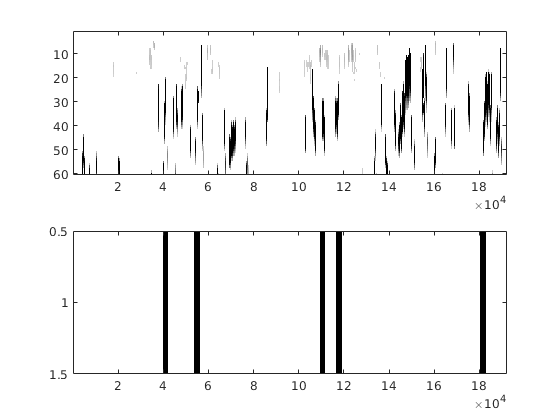

In [18]:
subplot(2,1,1)
imagesc(abs(xpol_minus_median_thresholded))
colormap(cmap)
subplot(2,1,2)
imagesc(human_labels)
colormap(cmap)

## Moving standard deviation

### Without thresholding

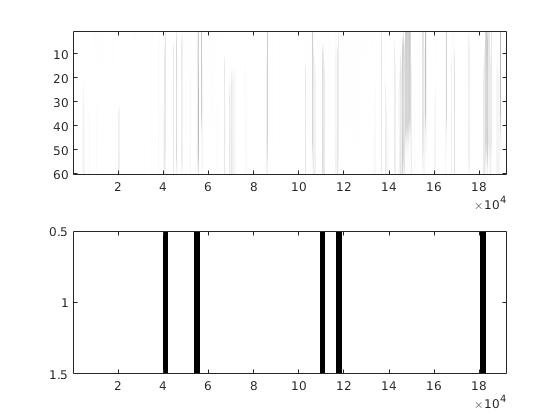

In [19]:
subplot(2,1,1)
imagesc(xpol_std)
colormap(cmap)
subplot(2,1,2)
imagesc(human_labels)
colormap(cmap)

### With thresholding applied before taking the standard deviation

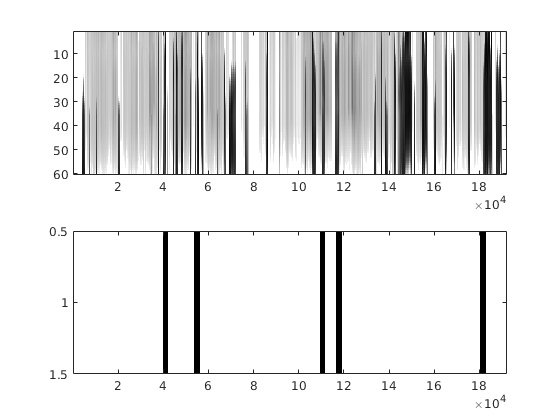

In [20]:
subplot(2,1,1)
imagesc(xpol_thresholded_std)
colormap(cmap)
subplot(2,1,2)
imagesc(human_labels)
colormap(cmap)